# Marginal Costs

Gets marginal cost values from base network (no-dr) to use as a scenario dimension

In [1]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pathlib import Path

In [2]:
SCENARIO = "er20" # "er20" | "er35" | "er50"
DATA = Path("..","data","networks", "static") # static and dynamic bases are the same
FIGURES = Path("..","figures","marginalcost") 
INTERCONNECT = "western"
NETWORK_NAME = "elec_s70_c4m_ec_lv1.0_1h-TCT_E-G"

In [3]:
network = Path(DATA, SCENARIO, INTERCONNECT, "networks",  f"{NETWORK_NAME}.nc")
n = pypsa.Network(network)

INFO:pypsa.io:Imported network elec_s70_c4m_ec_lv1.0_1h-TCT_E-G.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


In [28]:
SECTORS = {
    "res": "Residential",
    "com": "Commercial",
    "ind": "Industrial",
    "trn": "Transportation",
}

NICE_NAME_FIX = {
    "Residential Electrical": "Electrical",
    "Commercial Electrical": "Electrical",
    "Industrial Electrical": "Electrical",
    "Industrial Heating": "Heating",
}

In [5]:
def get_marginal_cost(n: pypsa.Network) -> pd.DataFrame:
    """Average marginal costs per carrier"""
    return n.buses_t["marginal_price"].rename(columns=n.buses.carrier).T.groupby(level=0).mean().T

def filter_carriers_in_sector(df: pd.DataFrame, sector: str) -> pd.DataFrame:
    """Filters out carriers 
    
    Cant use load buses as transport dr is not attached directly at load
    """
    if sector in ("res", "com"):
        return df[[x for x in df if "-water-" not in x]].copy()
    elif sector in ("trn"):
        return df[["trn-elec-veh", "trn-lpg-veh"]].copy()
    else:
        return df.copy()
    
def assign_nice_names(n: pypsa.Network, df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns=n.carriers.nice_name).rename(columns=NICE_NAME_FIX)

def get_mc_per_sector(n: pypsa.Network, sector: str, nice_name: bool = True) -> pd.DataFrame:
    """Get marginal costs in the sector"""
    assert sector in ("res", "com", "ind", "trn")
    df = get_marginal_cost(n)
    df = df[[x for x in df if sector in x]]
    df = filter_carriers_in_sector(df, sector)
    
    if nice_name:
        return assign_nice_names(n, df)
    else:
        return df
    
def apply_averages(df: pd.DataFrame) -> pd.DataFrame:
    yearly_average = df.mean().mean()
    # df["Average"] = df.mean(axis=1)
    df["Average"] = yearly_average
    print(f"Average yearly cost is: {yearly_average}")
    return df

def apply_averages_carrier(df: pd.DataFrame) -> pd.DataFrame:
    averages = df.mean(axis=0)
    for car in averages.index:
        cost = averages.loc[car]
        df[f"{car} Average"] = cost
        print(f"Average yearly cost of {car}: {cost}")
    return df

In [34]:
def plot_costs(n: pypsa.Network, sector: str, by_carrier: bool = False, resample: str = "D", **kwargs) -> tuple:
    
    colors = {
        "Electrical": "tab:olive",
        "Space Heat": "tab:red",
        "Cool": "tab:blue",
        "other": "black",
        "Heating": "tab:red",
        "Electric Vehicles": "tab:olive",
        "Gas Vehicles": "tab:purple"
    }
    linestyles = {
        "carrier":"-",
        "other":"--"
    }
    
    costs = get_mc_per_sector(n, sector)
    if by_carrier:
        costs = apply_averages_carrier(costs)
    else:
        costs = apply_averages(costs)
    
    period = n.investment_periods[0]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
    
    df = costs.loc[period].resample(resample).mean()
    
    ylabel = "$/MWh"
    title = f"{SECTORS[sector]} Cost of Energy"
    
    lines = []

    for col in df.columns:
        if col.endswith("Average"):
            color = colors["other"]
            linestyle = linestyles["other"]
            linewidth=1
        else:
            color = colors[col]
            linestyle = linestyles["carrier"]
            linewidth=2
            lines.append(mlines.Line2D([], [], color=color, linestyle=linestyle, label=col))
            
        ax.plot(df.index, df[col], color=color, linestyle=linestyle, linewidth=linewidth)
        
    lines.append(mlines.Line2D([], [], color=colors["other"], linestyle=linestyles["other"], label="DR Price"))

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    
    ylim = kwargs.get("ylim", None)
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
        
    xlim = (df.index[0], df.index[-1])
    ax.set_xlim(xlim[0], xlim[1])

    # fig.legend(handles, labels, loc="center left", bbox_to_anchor=(0.9, 0.5), title="")
    ax.legend(handles=lines, loc="center left", bbox_to_anchor=(1.02, 0.5), title="")
    
    plt.tight_layout()
        
    return fig, ax

Average yearly cost is: 49.76342249878934


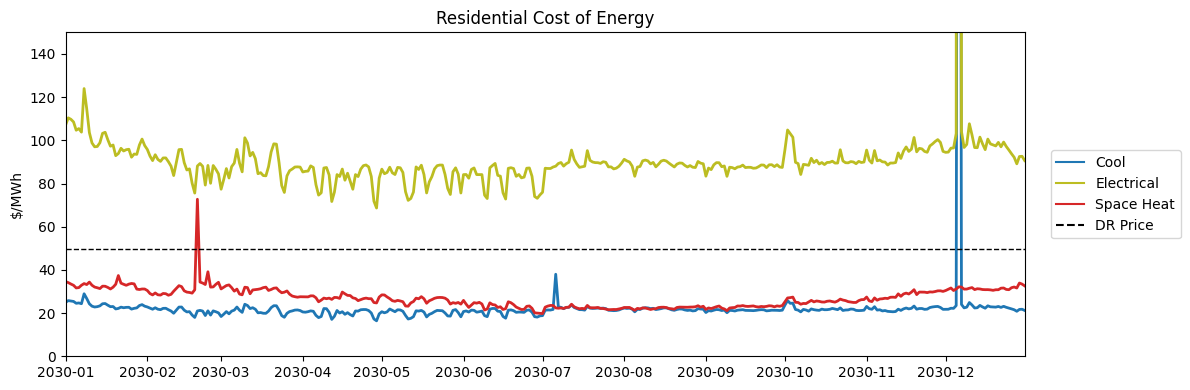

In [14]:
fig, _ = plot_costs(n, "res", ylim=(0,150), by_carrier=False)
fig.savefig(Path(FIGURES, "static", "residential.png"))

Average yearly cost of Cool: 23.623030279798403
Average yearly cost of Electrical: 98.6429569681775
Average yearly cost of Space Heat: 27.024280248392127


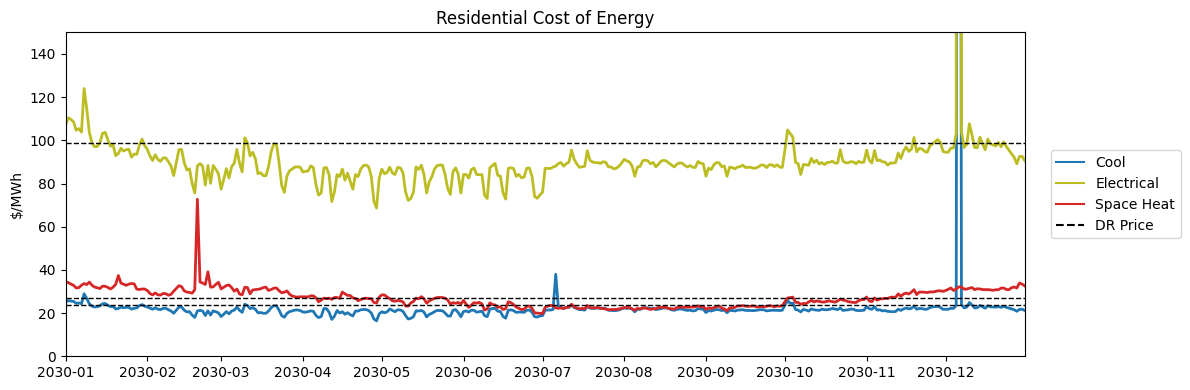

In [15]:
fig, _ = plot_costs(n, "res", ylim=(0,150), by_carrier=True)
fig.savefig(Path(FIGURES, "dynamic", "residential.png"))

Average yearly cost is: 50.125811689387035


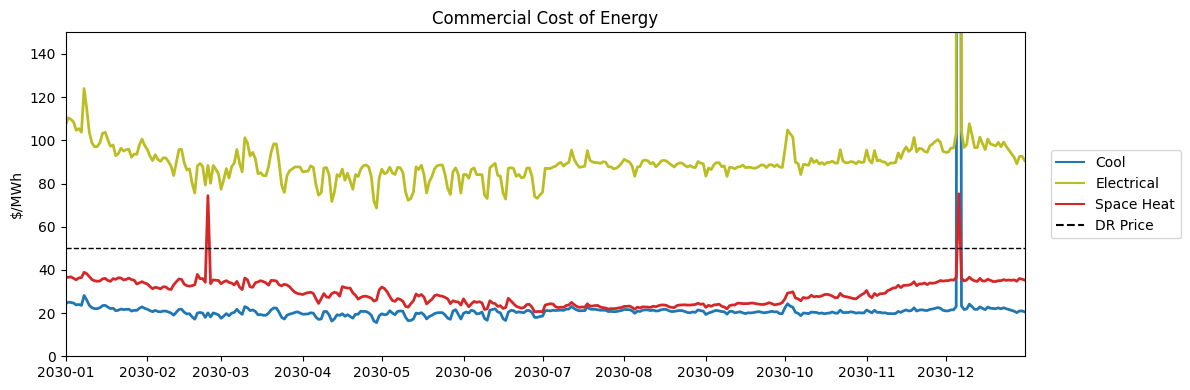

In [17]:
fig, _ = plot_costs(n, "com", ylim=(0,150), by_carrier=False)
fig.savefig(Path(FIGURES, "static", "commercial.png"))

Average yearly cost of Cool: 22.6557351213311
Average yearly cost of Electrical: 98.64321921582138
Average yearly cost of Space Heat: 29.07848073100862


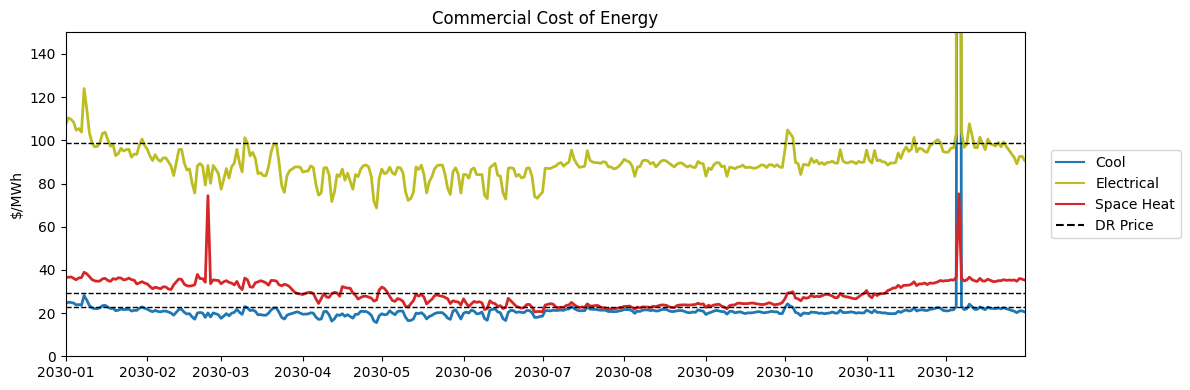

In [18]:
fig, _ = plot_costs(n, "com", ylim=(0,150), by_carrier=True)
fig.savefig(Path(FIGURES, "dynamic", "commercial.png"))

Average yearly cost is: 59.84641771397332


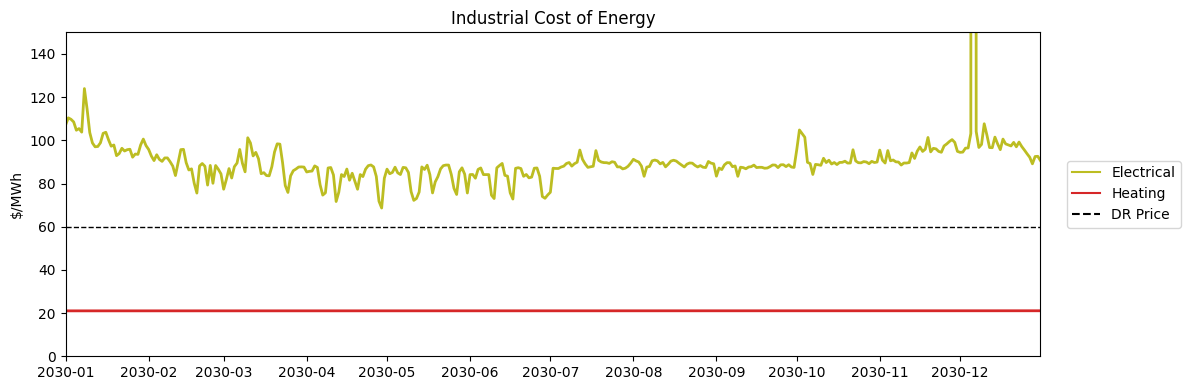

In [29]:
fig, _ = plot_costs(n, "ind", ylim=(0,150), by_carrier=False)
fig.savefig(Path(FIGURES, "static", "industrial.png"))

Average yearly cost of Electrical: 98.64318141061445
Average yearly cost of Heating: 21.049654017332188


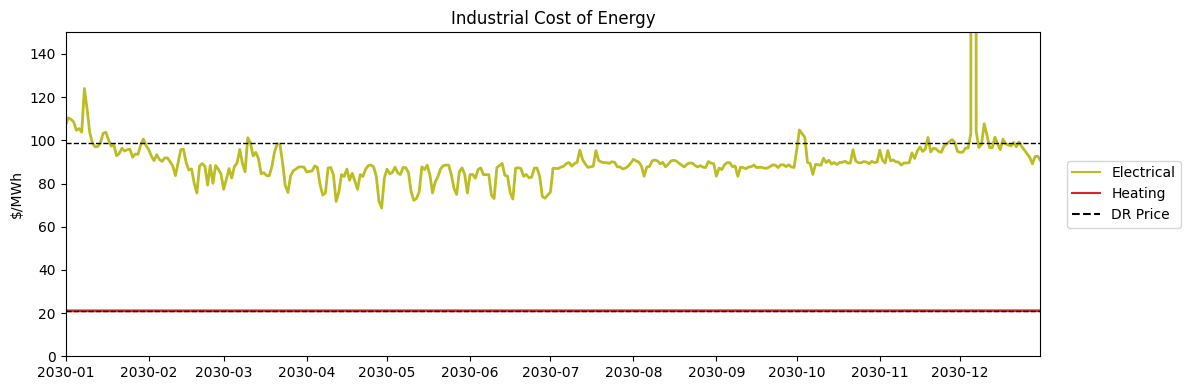

In [30]:
fig, _ = plot_costs(n, "ind", ylim=(0,150), by_carrier=True)
fig.savefig(Path(FIGURES, "dynamic", "industrial.png"))

Average yearly cost is: 59.057134384762904


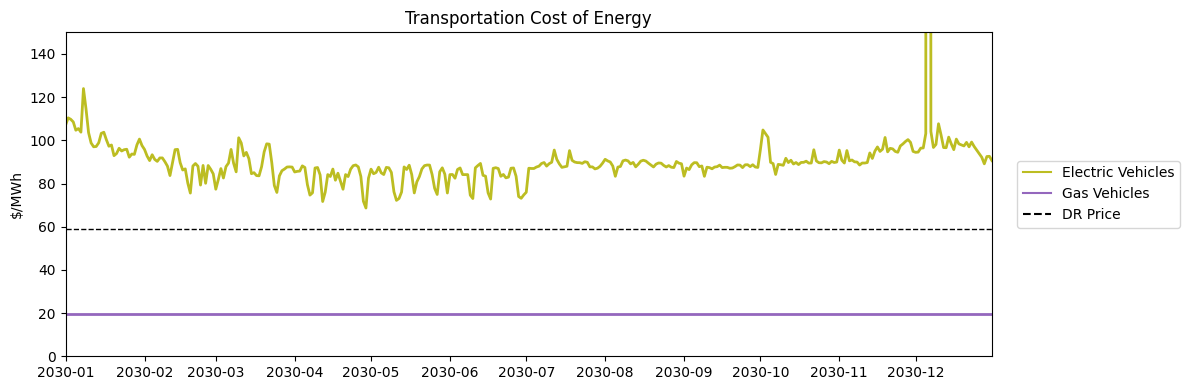

In [36]:
fig, _ = plot_costs(n, "trn", ylim=(0,150), by_carrier=False)
fig.savefig(Path(FIGURES, "static", "transport.png"))

Average yearly cost of Electric Vehicles: 98.64278859432906
Average yearly cost of Gas Vehicles: 19.47148017519674


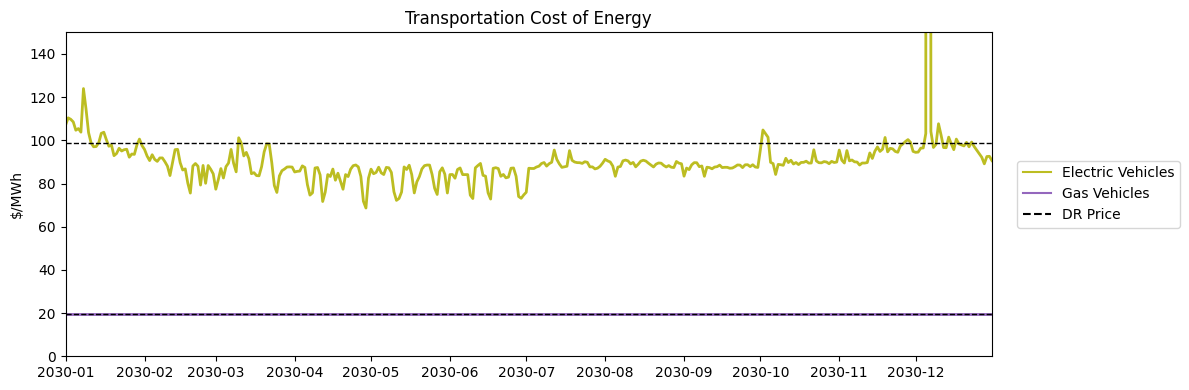

In [35]:
fig, _ = plot_costs(n, "trn", ylim=(0,150), by_carrier=True)
fig.savefig(Path(FIGURES, "dynamic", "transport.png"))